# Tutorial on Artificial Neural Networks using KERAS

The task here is predict whether the customer will leave the credit card company or not based on various customer attributes such as Credit Score, Gender, Age, Salary etc.

### Import Libraries

In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

seed = 1234

### Import data

In [118]:
df = pd.read_csv('churn_modelling.csv', index_col='RowNumber')
print('Column Names : ', df.columns.tolist())

Column Names :  ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


#### Get stats about data
These are statistics are necessary to check:
    1. Min, Max, standard deviation of different attributes
    2. Missing values
    3. Datatype of different values
    4. Data distribution of each column attribute
    5. Assess if certain column values are necessary or not

In [119]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [120]:
df.info()
# df.head()

# missing data
print('\n\nMissing values : ', df.isnull().any().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


Missing values :  False


### Visualizing Distribution

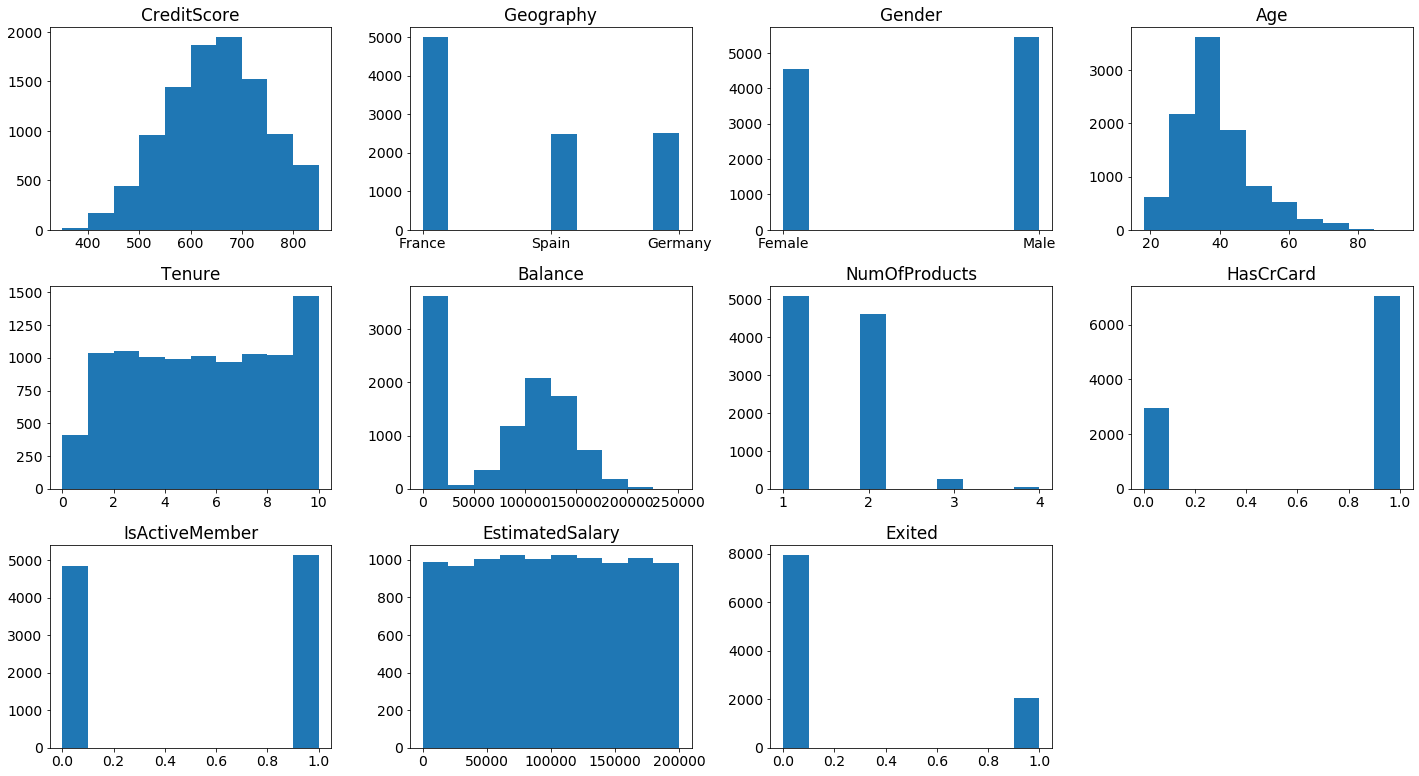

In [121]:
# name and customer id do not affect the outcome and hence are removed from the data
df = df.drop(axis=1, columns=['CustomerId', 'Surname'])

fig = plt.figure(figsize=(20, 11))
plt.rcParams.update({'font.size': 14})

for index, col_name in enumerate(df.columns.tolist()):
    plt.subplot(3, 4, index + 1)
    plt.hist(df[col_name])
    plt.title(col_name)

fig.tight_layout()
plt.savefig('data_distribution.png', bbox_inches='tight',
            dpi=150, facecolor='silver', edgecolor='black')

### Encoding Categorical Variables
The categorical variables or the attributes which are string values such as country names or gender need to be represented as integers. For this purpose we require __label encoder__. This is solves the problem partially only. If there are more than two categorical values, then for the neural network certain categories will have higher weightage than the others. In the example above, there are 3 countries. They are assigned labels 0, 1, 2 respectively. The neural network will consider that the category with label 2 has higher value than the one with label 0. To give equal weightage, each of these integral labels are converted to an array of 1's and 0's. For this purpose we require __one-hot encoder__.  The scikit learn library has a new library called __ColumnTransformer__ which combines both the function. The __fit_transform__ method is used to transform the data.

In [122]:
def data_encoding(dataframe):
    # get categorical column names
    categorical_features = dataframe.dtypes == object
    categorical_columns = dataframe.columns[categorical_features].tolist()
    print(categorical_columns)

    # apply one hot encoding for required column
    ct = ColumnTransformer(transformers=[('one_hot_encoder',
                                          OneHotEncoder(categories='auto'),
                                          [1, 2])],
                           remainder='passthrough')

    dataframe = ct.fit_transform(dataframe)

    dump(ct, open('transformer.pkl', 'wb'))
    return dataframe


df = data_encoding(df)

['Geography', 'Gender']


### Split data into train and test samples
The collective data is divided into two parts, the training dataset to train the model and the test dataset to check the performance of trained model on unseen data. __This is done using train_test_split method.__ As different attributes have different range of values, the neural network will take very long time to converge and give meaningful predictions. Therefore the data needs to be normalized or standardized. __Here fit_transform method from MinMaxScaler object is used to transform all values between 0 and 1.__

In [123]:
X_train.shape

(8000, 13)

In [124]:
X = df[:, :-1]
y = df[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True)

# scaling values to be in between [0, 1]
col_trans_list = [5, 6, 7, 8, 9, 12]
scaler = MinMaxScaler()
X_train[:, col_trans_list] = scaler.fit_transform(X_train[:, col_trans_list])
X_test[:, col_trans_list] = scaler.transform(X_test[:, col_trans_list])
dump(scaler, open('minmaxscaler.pkl', 'wb'))

### Model designing
EarlyStopping is keras callback used to stop the training of the model based on certain criteria. Here value of validation loss is used as stopping criteria. The training data is again split into two datasets: training and validation dataset. The validation dataset is used to check the performance of the model during its training on the training data. The model is trained using __fit__ method of Keras.

Common practice is to use __'relu'__ activation function for intermediate hidden layers. For output layer, __'sigmoid' or 'tanh'__ activation functions is used for binary classification problems and correspondingly __'binary_crossentropy'__ as loss function. For multi-class problems, __'softmax'__ is used as output layer activation function and __'categorical_crossentropy'__ as loss function.

In [126]:
def create_ann():
    model = Sequential()
    model.add(Dense(units=512,  # number of neurons
                    activation='relu',  # activation function
                    kernel_initializer=glorot_uniform(seed),  # weight initialization
                    input_dim=X_train.shape[1],  # number of features
                    name='layer_1'))
    model.add(Dropout(rate=0.2))  # removing weights to improve performance

    model.add(Dense(units=512,
                    activation='relu',
                    kernel_initializer=glorot_uniform(seed),
                    name='layer_2'))
    model.add(Dropout(rate=0.3))

    model.add(Dense(units=128,
                    activation='relu',
                    kernel_initializer=glorot_uniform(seed),
                    name='layer_3'))
    model.add(Dropout(rate=0.2))
    
    model.add(Dense(units=1, activation='sigmoid',
                    name='output_layer'))

    model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


network = create_ann()
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
# training the model
history = network.fit(x=X_train, y=y_train,
                      validation_split=0.2,
                      batch_size=128,
                      callbacks=[es],
                      epochs=1000,
                      verbose=0)

# Save Model
network.save('ann_model.h5')

### Visualize model parameters
To determine when overfitting starts

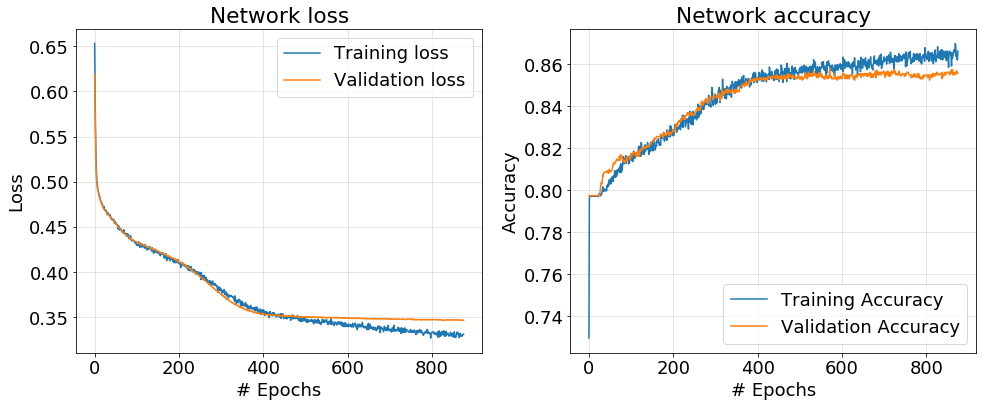

In [127]:
def get_model_param_plot():
    fig = plt.figure(figsize=(14, 6))
    plt.rcParams.update({'font.size': '18'})
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Network loss')
    plt.xlabel('# Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.4)
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Network accuracy')
    plt.xlabel('# Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.4)
    plt.legend(loc='best')

    fig.tight_layout()
    fig.savefig('model_parameters.jpg', bbox_inches='tight',
                dpi=150, facecolor='grey', edgecolor='black')


get_model_param_plot()

### Model Evaluation
__evaluate__ method gives the model accuracy and loss metrics

In [128]:
params = network.evaluate(X_test, y_test)
print('Model Loss : {:.3f}, Model Accuracy : {:.3f} % \n'
      .format(params[0], params[1] * 100))


2000/2000 [==============================] - 0s 148us/sample - loss: 0.3391 - accuracy: 0.8630
Model Loss : 0.339, Model Accuracy : 86.300 % 



### Model Prediction
For predictions, the new input values are required to be pre-processed therefore the saved preprocessing object are loaded

In [103]:
# model prediction
n = 100
y_pred = network.predict(X_test[n].reshape(1, -1))[0]
y_pred = np.where(y_pred < 0.5, 0, 1)[0]
y_true = y_test[n]


print('True Value: {}, Predicted Value: {}'
     .format(y_true, y_pred))

True Value: 0.0, Predicted Value: 0


In [129]:
# model prediction from saved models
from pickle import load
from tensorflow.keras.models import load_model

# load data pre-processing object
data_prep_1 = load(open('transformer.pkl', 'rb'))
data_prep_2 = load(open('minmaxscaler.pkl', 'rb'))

# load trained model
model = load_model('ann_model.h5')

# accept user input & process the data for model
# change the value of each key to find the results. "Exited" is the true value
user_dict = {'CreditScore': 608, 'Geography': 'Spain', 'Gender': 'Female',
             'Age': 41, 'Tenure':1, 'Balance': 83807.86, 'NumOfProducts': 1,
             'HasCrCard': 0, 'IsActiveMember': 1,
             'EstimatedSalary': 112542.58, 'Exited': 0}

user_input = pd.DataFrame(user_dict, index=[0])
user_input = data_prep_1.transform(user_input)
col_trans_list = [5, 6, 7, 8, 9, 12]
user_input[:, col_trans_list] = data_prep_2.transform(user_input[:, col_trans_list])

# start prediction
prediction = model.predict(user_input[0, :-1].reshape(1, -1))
prediction = np.where(prediction < 0.5, 0, 1)[0]

print('True Value: {}, Predicted Value: {}'
     .format(user_input[0, -1], y_pred))

True Value: 0.0, Predicted Value: 0
